In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!pip install tqdm


    100% |████████████████████████████████| 51kB 2.3MB/s 


# Name Generation using RNN
We will generate new names for people using RNN

In [0]:
import tensorflow as tf
from numpy.random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


##  Data loading

In [0]:
# for loading data
def load_data(filename):
    with open(filename, 'r') as f:
        data = f.read().lower().split('\n')
    return np.array(data)

In [429]:
data = load_data('drive/Colab Notebooks/name_list.txt')
print('No. of names: ' + str(len(data)))

No. of names: 4095


Split data into training and validation set

In [430]:
# split data
train_data, val_data = train_test_split(data, test_size=0.05)
print(len(train_data))
print(len(val_data))

3890
205


## Text Processing
We will use a character level model for this task. So first we will create a vocabulary dictionary. Since this is a character level model so the only the vocabulary size is fixed. 

In [431]:
# find the unique characters for the vocabulary
#  Here '#' means End of Sentence
vocab_tokens = ['#'] + list(set(''.join(data)))
vocab_tokens_len = len(vocab_tokens)
print(vocab_tokens_len)

29


In [432]:
# find the max length amongst names
max_name_len = max(len(name) for name in train_data)
print('Max length: ', max_name_len)

Max length:  15


For training the model we need to represent the string characters in terms of numbers. For that we will create a dictionary mapping of characters and numerical indices and vice-versa.

In [433]:
# create vocabulary dict 
# character to index
ch_to_idx = {ch:idx for idx, ch in tqdm(enumerate(vocab_tokens))}
print('\nDict len: ', len(ch_to_idx))
print(ch_to_idx)

# index to chracter
idx_to_ch = {ch_to_idx[ch]:ch for ch in ch_to_idx.keys()}
print('\nDict len: ', len(idx_to_ch))
print(idx_to_ch)

29it [00:00, 64527.75it/s]


Dict len:  29
{'#': 0, 'y': 1, 'm': 2, 'z': 3, 'a': 4, 'u': 5, 'n': 6, 'g': 7, 'h': 8, 'r': 9, 'l': 10, 's': 11, 'k': 12, 'o': 13, ';': 14, 'b': 15, 'f': 16, 'p': 17, 'e': 18, 'w': 19, 'q': 20, 'c': 21, '(': 22, 'x': 23, 'i': 24, 'v': 25, 'j': 26, 'd': 27, 't': 28}

Dict len:  29
{0: '#', 1: 'y', 2: 'm', 3: 'z', 4: 'a', 5: 'u', 6: 'n', 7: 'g', 8: 'h', 9: 'r', 10: 'l', 11: 's', 12: 'k', 13: 'o', 14: ';', 15: 'b', 16: 'f', 17: 'p', 18: 'e', 19: 'w', 20: 'q', 21: 'c', 22: '(', 23: 'x', 24: 'i', 25: 'v', 26: 'j', 27: 'd', 28: 't'}


In [0]:
# for converting string names to matrix representation consisting of numerical indices
# output shape: (m, Tx)
def to_num_matrix(names, ch_to_idx):
    
    max_len = max(map(len, names))
    names_idx = np.zeros((len(names), max_len), dtype='int32')
        
    for i, name in enumerate(names):
        for j, ch in enumerate(name):
            names_idx[i][j] = ch_to_idx[ch]
        
    return names_idx

In [435]:
to_num_matrix(train_data, ch_to_idx).shape

(3890, 15)

## Training
This is a simple model using Vanilla Recurrent units.

In [0]:
from IPython.display import clear_output
from random import sample
import pickle
import sys

In [0]:
from keras.layers import Embedding, Dense, Concatenate
import keras
import keras.layers as L
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import Sequential, load_model

In [0]:
# for finding the validation accuracy
def compute_acc():
    # convert validation data
    val_x = to_num_matrix(val_data, ch_to_idx)
    # validation labels
    val_y = np.copy(val_x[:,1:])
    
    # leave the last character
    pred = model.predict(val_x[:,:-1], batch_size=256, verbose=1)
    pred_ch = pred.argmax(axis=-1)
    
    # find acc
    return float(np.sum(np.logical_and((pred_ch!=0), (pred_ch == val_y)))) \
                / np.sum(val_y != 0)

In [0]:
# custom callback
def acc_on_epoch_end(epoch, logs):
    sys.stdout.flush()
    print('\nValidation Accuracy: ' + str(compute_acc()*100) + ' %')
    sys.stdout.flush()

In [0]:
# for generating batches
def generate_model_batches(names, batch_size=32, pad=0):
    # no. of training examples
    m = np.arange(len(names))
    
    while True:
        # get a shuffled index list
        idx = np.random.permutation(m)
        
        # start yeilding batches
        for start in range(0, len(idx)-1, batch_size):
            batch_idx = idx[start:start+batch_size]
            batch_words = []
            
            # take out the words and tags from 'batch_size' no. of training examples
            for index in batch_idx:
                batch_words.append(names[index])
            
            # input x
            batch_x = to_num_matrix(batch_words, ch_to_idx)
            
            # output labels 
            batch_y_ohe = to_categorical(batch_x[:,1:], len(vocab_tokens))
            yield batch_x[:,:-1], batch_y_ohe

## Model

In [0]:
acc_callback = LambdaCallback(on_epoch_end=acc_on_epoch_end)
checkpoint = ModelCheckpoint('drive/Colab Notebooks/best_weights.h5', verbose=1, save_best_only=True)

In [461]:
model = Sequential()
model.add(L.InputLayer([None], dtype='int32'))
# embeddings layer
model.add(L.Embedding(len(vocab_tokens), 20))

# gru layer
model.add(L.GRU(128, return_sequences=True, activation='tanh'))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())


# apply softmax
model.add(L.TimeDistributed(L.Dense(len(vocab_tokens), activation='softmax')))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, None, 20)          580       
_________________________________________________________________
gru_29 (GRU)                 (None, None, 128)         57216     
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
batch_normalization_29 (Batc (None, None, 128)         512       
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 29)          3741      
Total params: 62,049
Trainable params: 61,793
Non-trainable params: 256
_________________________________________________________________


In [462]:
BATCH_SIZE = 256

# select optimizer
optimizer = keras.optimizers.Adam(clipvalue=1.2)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train model
hist = model.fit_generator(generate_model_batches(train_data, batch_size=BATCH_SIZE), steps_per_epoch=len(train_data)/BATCH_SIZE,
                          callbacks=[acc_callback, checkpoint], epochs=100)

Epoch 1/100
205/205 [==============================] - 2s 9ms/step

Validation Accuracy: 8.10580204778157 %
Epoch 2/100
 3/15 [====>.........................] - ETA: 0s - loss: 2.2915 - acc: 0.4534

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


205/205 [==============================] - 0s 47us/step

Validation Accuracy: 16.040955631399317 %
Epoch 3/100
205/205 [==============================] - 0s 65us/step

Validation Accuracy: 26.27986348122867 %
Epoch 4/100
205/205 [==============================] - 0s 50us/step

Validation Accuracy: 34.38566552901024 %
Epoch 5/100
205/205 [==============================] - 0s 50us/step

Validation Accuracy: 32.67918088737201 %
Epoch 6/100
205/205 [==============================] - 0s 62us/step

Validation Accuracy: 33.36177474402731 %
Epoch 7/100
205/205 [==============================] - 0s 69us/step

Validation Accuracy: 35.06825938566553 %
Epoch 8/100
205/205 [==============================] - 0s 48us/step

Validation Accuracy: 34.470989761092156 %
Epoch 9/100
205/205 [==============================] - 0s 56us/step

Validation Accuracy: 34.38566552901024 %
Epoch 10/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 35.580204778157 %
Epoch 11/100
 6/15 [=

205/205 [==============================] - 0s 63us/step

Validation Accuracy: 34.8122866894198 %
Epoch 12/100
205/205 [==============================] - 0s 67us/step

Validation Accuracy: 36.177474402730375 %
Epoch 13/100
205/205 [==============================] - 0s 53us/step

Validation Accuracy: 35.665529010238906 %
Epoch 14/100
205/205 [==============================] - 0s 55us/step

Validation Accuracy: 35.92150170648464 %
Epoch 15/100
205/205 [==============================] - 0s 54us/step

Validation Accuracy: 36.092150170648466 %
Epoch 16/100
205/205 [==============================] - 0s 62us/step

Validation Accuracy: 35.83617747440273 %
Epoch 17/100
205/205 [==============================] - 0s 49us/step

Validation Accuracy: 35.665529010238906 %
Epoch 18/100
205/205 [==============================] - 0s 57us/step

Validation Accuracy: 35.23890784982935 %
Epoch 19/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 35.580204778157 %
Epoch 20/100


205/205 [==============================] - 0s 60us/step

Validation Accuracy: 36.262798634812285 %
Epoch 21/100
205/205 [==============================] - 0s 49us/step

Validation Accuracy: 34.641638225255974 %
Epoch 22/100
205/205 [==============================] - 0s 53us/step

Validation Accuracy: 36.177474402730375 %
Epoch 23/100
205/205 [==============================] - 0s 48us/step

Validation Accuracy: 35.49488054607509 %
Epoch 24/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 35.153583617747444 %
Epoch 25/100
205/205 [==============================] - 0s 58us/step

Validation Accuracy: 35.750853242320815 %
Epoch 26/100
205/205 [==============================] - 0s 64us/step

Validation Accuracy: 35.49488054607509 %
Epoch 27/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 36.00682593856656 %
Epoch 28/100
205/205 [==============================] - 0s 56us/step

Validation Accuracy: 33.70307167235495 %
Epoch 29/

205/205 [==============================] - 0s 57us/step

Validation Accuracy: 34.98293515358362 %
Epoch 30/100
205/205 [==============================] - 0s 56us/step

Validation Accuracy: 34.8122866894198 %
Epoch 31/100
205/205 [==============================] - 0s 65us/step

Validation Accuracy: 32.508532423208194 %
Epoch 32/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 34.55631399317406 %
Epoch 33/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 34.8976109215017 %
Epoch 34/100
205/205 [==============================] - 0s 48us/step

Validation Accuracy: 33.020477815699664 %
Epoch 35/100
205/205 [==============================] - 0s 47us/step

Validation Accuracy: 34.129692832764505 %
Epoch 36/100
205/205 [==============================] - 0s 55us/step

Validation Accuracy: 33.617747440273035 %
Epoch 37/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 33.95904436860068 %
Epoch 38/100

205/205 [==============================] - 0s 54us/step

Validation Accuracy: 32.84982935153584 %
Epoch 39/100
205/205 [==============================] - 0s 52us/step

Validation Accuracy: 34.129692832764505 %
Epoch 40/100
205/205 [==============================] - 0s 58us/step

Validation Accuracy: 32.93515358361775 %
Epoch 41/100
205/205 [==============================] - 0s 58us/step

Validation Accuracy: 35.665529010238906 %
Epoch 42/100
205/205 [==============================] - 0s 58us/step

Validation Accuracy: 33.70307167235495 %
Epoch 43/100
205/205 [==============================] - 0s 56us/step

Validation Accuracy: 31.48464163822526 %
Epoch 44/100
205/205 [==============================] - 0s 69us/step

Validation Accuracy: 33.36177474402731 %
Epoch 45/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 35.23890784982935 %
Epoch 46/100
205/205 [==============================] - 0s 62us/step

Validation Accuracy: 35.40955631399317 %
Epoch 47/100

205/205 [==============================] - 0s 53us/step

Validation Accuracy: 34.470989761092156 %
Epoch 48/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 33.87372013651877 %
Epoch 49/100
205/205 [==============================] - 0s 57us/step

Validation Accuracy: 33.44709897610921 %
Epoch 50/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 32.76450511945392 %
Epoch 51/100
205/205 [==============================] - 0s 55us/step

Validation Accuracy: 35.32423208191126 %
Epoch 52/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 34.8122866894198 %
Epoch 53/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 35.40955631399317 %
Epoch 54/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 35.153583617747444 %
Epoch 55/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 34.8122866894198 %
Epoch 56/100
 

205/205 [==============================] - 0s 59us/step

Validation Accuracy: 33.44709897610921 %
Epoch 57/100
205/205 [==============================] - 0s 57us/step

Validation Accuracy: 34.641638225255974 %
Epoch 58/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 33.87372013651877 %
Epoch 59/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 35.06825938566553 %
Epoch 60/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 35.580204778157 %
Epoch 61/100
205/205 [==============================] - 0s 57us/step

Validation Accuracy: 36.262798634812285 %
Epoch 62/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 37.116040955631405 %
Epoch 63/100
205/205 [==============================] - 0s 49us/step

Validation Accuracy: 35.665529010238906 %
Epoch 64/100
205/205 [==============================] - 0s 49us/step

Validation Accuracy: 32.84982935153584 %
Epoch 65/100

205/205 [==============================] - 0s 59us/step

Validation Accuracy: 32.25255972696246 %
Epoch 66/100
205/205 [==============================] - 0s 50us/step

Validation Accuracy: 34.38566552901024 %
Epoch 67/100
205/205 [==============================] - 0s 49us/step

Validation Accuracy: 34.470989761092156 %
Epoch 68/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 34.8976109215017 %
Epoch 69/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 35.23890784982935 %
Epoch 70/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 34.38566552901024 %
Epoch 71/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 33.532423208191126 %
Epoch 72/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 33.532423208191126 %
Epoch 73/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 33.87372013651877 %
Epoch 74/100

205/205 [==============================] - 0s 52us/step

Validation Accuracy: 34.55631399317406 %
Epoch 75/100
205/205 [==============================] - 0s 59us/step

Validation Accuracy: 34.8976109215017 %
Epoch 76/100
205/205 [==============================] - 0s 70us/step

Validation Accuracy: 34.98293515358362 %
Epoch 77/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 34.98293515358362 %
Epoch 78/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 34.55631399317406 %
Epoch 79/100
205/205 [==============================] - 0s 50us/step

Validation Accuracy: 33.44709897610921 %
Epoch 80/100
205/205 [==============================] - 0s 64us/step

Validation Accuracy: 31.569965870307165 %
Epoch 81/100
205/205 [==============================] - 0s 56us/step

Validation Accuracy: 32.67918088737201 %
Epoch 82/100
205/205 [==============================] - 0s 69us/step

Validation Accuracy: 33.95904436860068 %
Epoch 83/100
 

205/205 [==============================] - 0s 51us/step

Validation Accuracy: 34.470989761092156 %
Epoch 84/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 33.44709897610921 %
Epoch 85/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 32.081911262798634 %
Epoch 86/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 32.76450511945392 %
Epoch 87/100
205/205 [==============================] - 0s 64us/step

Validation Accuracy: 34.8122866894198 %
Epoch 88/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 35.92150170648464 %
Epoch 89/100
205/205 [==============================] - 0s 63us/step

Validation Accuracy: 33.19112627986348 %
Epoch 90/100
205/205 [==============================] - 0s 52us/step

Validation Accuracy: 34.215017064846414 %
Epoch 91/100
205/205 [==============================] - 0s 55us/step

Validation Accuracy: 35.23890784982935 %
Epoch 92/100

205/205 [==============================] - 0s 56us/step

Validation Accuracy: 34.8976109215017 %
Epoch 93/100
205/205 [==============================] - 0s 61us/step

Validation Accuracy: 35.83617747440273 %
Epoch 94/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 35.665529010238906 %
Epoch 95/100
205/205 [==============================] - 0s 64us/step

Validation Accuracy: 33.87372013651877 %
Epoch 96/100
205/205 [==============================] - 0s 52us/step

Validation Accuracy: 34.129692832764505 %
Epoch 97/100
205/205 [==============================] - 0s 60us/step

Validation Accuracy: 34.8976109215017 %
Epoch 98/100
205/205 [==============================] - 0s 64us/step

Validation Accuracy: 35.665529010238906 %
Epoch 99/100
205/205 [==============================] - 0s 51us/step

Validation Accuracy: 35.153583617747444 %
Epoch 100/100
205/205 [==============================] - 0s 62us/step

Validation Accuracy: 36.43344709897611 %


In [0]:
# save model 
model.save('drive/Colab Notebooks/model.h5')
model.save_weights('drive/Colab Notebooks/weights.h5')

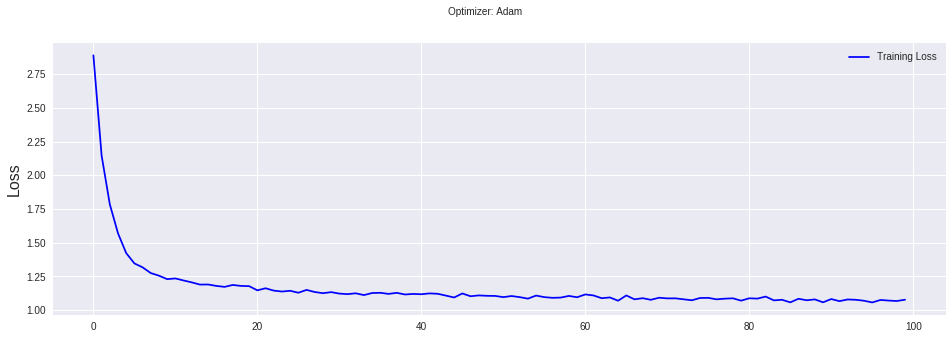

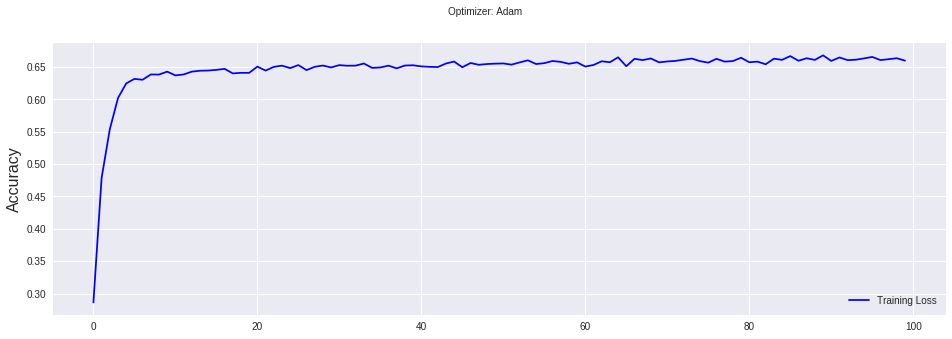

In [464]:
# loss plot
plt.figure(figsize=(16,5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')
plt.savefig('drive/Colab Notebooks/loss.png')

# acc plot
plt.figure(figsize=(16,5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Loss')
plt.legend(loc='lower right')

plt.savefig('drive/Colab Notebooks/acc.png')
plt.show()

## Sample Text

In [0]:
# samples text from language model
def sample_text(seed_phrase='a', max_length=max_name_len):
  
            
    # input x to numerical index
    text_x = to_num_matrix(list(list(seed_phrase)), ch_to_idx)
    # index of current character
    ch = ch_to_idx[seed_phrase]
    
    # list of predicted character indices
    indices = []
    # counter
    i = 0
    
    #start generating
    while ch != 0 and i<max_length:
        # predict using the input character
        pred = model.predict(text_x)[0]
        
        # get the char with highest prob.
        ch = np.random.choice(np.arange(len(vocab_tokens)) , p = pred.ravel())
        
        if ch!=0:
            indices.append(ch)
        
        # feed the current char as the next input
        text_x = to_num_matrix(list(list(idx_to_ch[ch])), ch_to_idx)
        
        i = i+ 1
    
    
    return ''.join([idx_to_ch[idx] for idx in indices])

In [472]:
i = 0
while i < 10:
    name = sample_text(max_length=6)
    if name != '':
        print(name)
        i += 1

rikata
denesh
nirami
pobhes
reeera
prabak
moodar
janika
fusuvm
rukami
